In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import scipy
import matplotlib.pyplot as plt

Source: climDAT: Data Analysis and Statistics with Martin Claus (SoSe 2022)

Commentary and docstrings as well as short code snippets were partly created with chatGPT

### Read in data

In [2]:
# Specify the file path to the saved (ASCII) file
file_path = 'noa_monthly.txt'

# Define the column names for the DataFrame
column_names = ['Year', 'Month', 'NAO']

# Read the ASCII file into a Pandas DataFrame with column names
data = pd.read_csv(file_path, sep='\s+', names=column_names)

# Display the DataFrame
print(data)

     Year  Month     NAO
0    1950      1  0.9200
1    1950      2  0.4000
2    1950      3 -0.3600
3    1950      4  0.7300
4    1950      5 -0.5900
..    ...    ...     ...
875  2022     12 -0.1456
876  2023      1  1.2503
877  2023      2  0.9227
878  2023      3 -1.1088
879  2023      4 -0.6284

[880 rows x 3 columns]


### Preprocess data and check if 'flawless'

In [3]:
def make_datetime_column(df):
    # Convert columns to appropriate data types
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['Month'] = pd.to_numeric(df['Month'], errors='coerce')

    # Create a datetime column from Year and Month
    df['Time'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))

    return df

def check_data(df, variable, resample_type='M'):
    """
    Checks the data for missing or false values and verifies the uniformity of the time step.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        variable (str): The column name of the variable to be checked.
        resample_type (str, optional): The resampling frequency to check for uniform time step. 
                    Defaults to 'M' for month.

    Raises:
        ValueError: If the data contains missing or false values or if the time step is non-uniform.

    Returns:
        None
    """
    
    # Check for missing or false values
    # the numbers 999.9 and -99.9 are used as placeholders to represent missing or false values in data
    if df[variable].isnull().any() or (df[variable] == 999.9).any() or (df[variable] == -99.99).any():
        raise ValueError('Data contains missing or false values. Preprocessing is required.')
    
    # Check for uniform time step
    valid_dates = df['Time'].notnull()
    time_diff = df['Time'].diff()
    
    # Find missing months
    monthly_df = df[valid_dates].set_index('Time').resample(resample_type).mean()
    missing_months = monthly_df[monthly_df.isnull().any(axis=1)]
    if not missing_months.empty:
        raise ValueError('Data contains non-uniform time step. Preprocessing is required. Missing times: {}'.format(missing_months.index))
        print(missing_months.index)
    
def preprocess_data(df, variable):
    """
    Preprocesses the given DataFrame by sorting it by date, filling any gaps in the data, and interpolating missing values.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        variable (str): The column name of the variable that will be preprocessed.

    Returns:
        pandas.DataFrame: The preprocessed DataFrame.
    """
    print('The missing values will be filled by interpolation. This will likely result in a flawed Fourier analysis.')
    print('Check if there are better alternatives.')
    
    # Sort the DataFrame by Date
    df = df.sort_values('Time')
    
    # Fill any gaps in the data
    min_date = df['Time'].min()
    max_date = df['Time'].max()
    all_dates = pd.date_range(min_date, max_date, freq='MS')
    df = df.set_index('Time').reindex(all_dates).reset_index()
    
    # Interpolate missing values
    df[variable] = df[variable].interpolate()
    df['Year'].fillna(method='ffill', inplace=True)
    df['Month'].fillna(method='ffill', inplace=True)
    df = df.rename(columns={'index': 'Time'})
    
    return df

In [4]:
df = make_datetime_column(data)

In [5]:
# Check if data preprocessing is required
try:
    check_data(df, 'NAO')
    print("Data seems ok.")
except ValueError as e:
    print(f"Error: {str(e)}")
    # Perform error handling or exit the program as needed

Data seems ok.


## Step by step Fourier analysis

### Fourier analysis of signal

In [6]:
def compute_power_spectrum(data, sampling_rate, method='basic'):
    """
    Compute the power spectrum of a given time series data.
    
    Args:
        data (numpy.ndarray): Time series data.
        
        sampling_rate (float): Sampling rate or frequency of the data.
        
        method: 'basic': basic technique to calculate periodogram
                    See scipy.signal.periodogram
                'welch': technique that reduces spectral leakage and improves the frequency resolution 
                    of the periodogram by dividing the signal into overlapping segments and 
                    averaging their periodograms. 
                    See scipy.signal.welch
                    
                not included but would be nice in future:
                'lomb-scargle': technique specifically designed for unevenly sampled time series data 
                    or non-uniformly spaced observations
                    See scipy.signal.lombscargle
        
    Returns:
        numpy.ndarray: Frequencies.
        numpy.ndarray: Power spectrum.
    """
    n = len(data)
    
    #frequencies = np.fft.fftfreq(n, 1/sampling_rate) # would be needed for lomb-scargle method
    
    # Compute the power spectrum 
    if method=='basic':
        frequencies, power_spectrum = signal.periodogram(data, sampling_rate)
    elif method=='welch':
        frequencies, power_spectrum = signal.welch(data, sampling_rate)
    else:
        print('Unknown method, please either use "basic", "welch".')
        

    # Apply normalization by multiplying with the degrees of freedom and dividing by the time interval
    power_spectrum = power_spectrum * (n-1) * sampling_rate
    
    try:
        return frequencies, power_spectrum
    except:
        pass

In [7]:
# Extract the NAO index values
index_values = df['NAO'].values

# Determine the sampling rate
time_interval = (df['Time'].iloc[1] - df['Time'].iloc[0]).days  # Assuming the time interval is in days
sampling_rate = 1 / time_interval

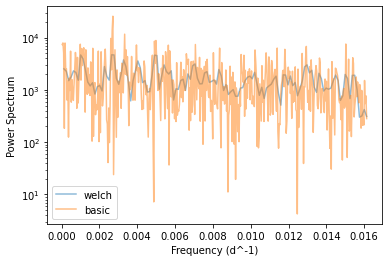

In [8]:
for method in ['welch', 'basic']:
    frequencies, power_spectrum = compute_power_spectrum(index_values, sampling_rate, method=method)
    plt.semilogy(frequencies[1:], power_spectrum[1:], alpha=0.5, label=method)

plt.legend()
plt.xlabel('Frequency (d^-1)')
plt.ylabel('Power Spectrum')

plt.show()

The x-axis might be nice to have in cycles per year

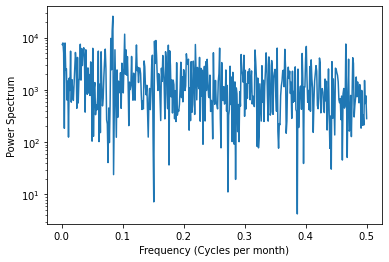

In [9]:
# Convert frequencies from cycles per day to cycles per month
frequencies_monthly = frequencies * 31

# Plot the power spectrum with yearly frequency
plt.semilogy(frequencies_monthly[1:], power_spectrum[1:])
plt.xlabel('Frequency (Cycles per month)')
plt.ylabel('Power Spectrum')
plt.show()

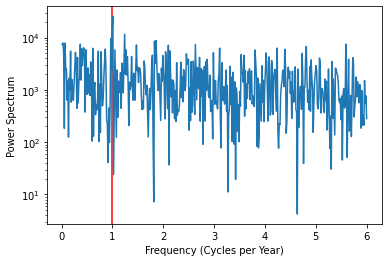

In [10]:
# Convert frequencies from cycles per day to cycles per month
frequencies_yearly = frequencies_monthly * 12

# Plot the power spectrum with yearly frequency
plt.axvline(1, color='r') 
plt.semilogy(frequencies_yearly[1:], power_spectrum[1:])
plt.xlabel('Frequency (Cycles per Year)')
plt.ylabel('Power Spectrum')
plt.show()

The highest peak has a frequency of once per year. The data weren't deseasonalized prior which should be done when analyzing data. 

### perform thorough check versus known noise (red/white noise)

In [11]:
def generate_red_noise(n, decay):
    """
    Generate red noise using an autoregressive (AR) process.
    
    Args:
        n (int): Length of the red noise time series.
        decay (float): Decay parameter controlling the rate of power decrease.
    
    Returns:
        numpy.ndarray: Red noise time series.
    """
    ar_coeff = [1, -decay]
    ma_coeff = [1]
    noise = np.random.normal(size=n)
    red_noise = signal.lfilter(ma_coeff, ar_coeff, noise)
    return red_noise

def generate_white_noise(n):
    """
    Generate white noise.
    
    Args:
        n (int): Length of the white noise time series.
    
    Returns:
        numpy.ndarray: White noise time series.
    """
    white_noise = np.random.normal(size=n)
    return white_noise

In [12]:
# Generate red noise
n = len(index_values)  # Length of the time series
decay = 0.6  # Decay parameter for red noise generation
red_noise = generate_red_noise(n, decay)

# Compute power spectrum of red noise
frequencies_red, power_spectrum_red = compute_power_spectrum(red_noise, sampling_rate)

In [13]:
# Generate white noise
white_noise = generate_white_noise(n)

# Compute power spectrum of white noise
frequencies_white, power_spectrum_white = compute_power_spectrum(white_noise, sampling_rate)

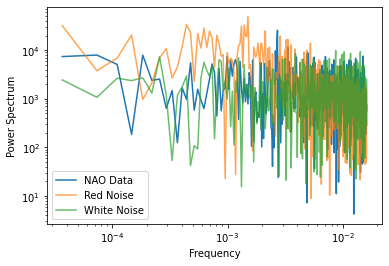

In [15]:
# Plot the power spectra
plt.plot(frequencies[1:], power_spectrum[1:], label='NAO Data')
plt.plot(frequencies_red[1:], power_spectrum_red[1:], label='Red Noise', linestyle='-', alpha=0.7)
plt.plot(frequencies_white[1:], power_spectrum_white[1:], label='White Noise', linestyle='-', alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

NAO data looks most like white noise.

### Compute 95% and 98% confidence intervals.

In [16]:
import scipy.stats

def calculate_confidence_intervals(power_spectrum, significance_levels):
    """
    Calculates confidence intervals for a given power spectrum based on significance levels.

    Args:
        power_spectrum (numpy.ndarray): The power spectrum or power spectral density.
        significance_levels (list): A list of significance levels for which to calculate the confidence intervals.

    Returns:
        list: A list of confidence intervals, each represented as [lower_bound, upper_bound].
    """

    # To obtain confidence intervals, we use the fact that for a power spectrum or power spectral density,
    # the ratio of the estimate to the true value is χ2 distributed with ν = 2 degrees of freedom for each frequency.
    
    confidence_intervals = []
    degrees_of_freedom = 2
    
    for level in significance_levels:
        # Calculate the critical value for the current significance level
        critical_value1 = scipy.stats.chi2.ppf(level / 2, degrees_of_freedom)
        critical_value2 = scipy.stats.chi2.ppf(1 - level / 2, degrees_of_freedom)
        
        # Calculate the confidence interval
        confidence_interval_lower = critical_value1 * power_spectrum / degrees_of_freedom
        confidence_interval_upper = critical_value2 * power_spectrum / degrees_of_freedom
        
        confidence_intervals.append([confidence_interval_lower, confidence_interval_upper])
    
    return confidence_intervals


def calculate_percentage_within_confidence(top, bottom, additional):
    count = 0
    if any((bottom <= additional) & (additional <= top)):
        count += 1
    percentage = (count / 1) * 100  # Divide by 1 to represent a single value
    return percentage


def plot_power_spectrum_with_confidence_intervals(frequencies, power_spectrum, confidence_intervals, significance_levels):

    for i in range(len(significance_levels)):
        # Plot the power spectrum
        plt.plot(frequencies, power_spectrum, label='Power Spectrum')
    
        # Plot the confidence intervals
        lower_bound = confidence_intervals[i][0]
        upper_bound = confidence_intervals[i][1]
        plt.fill_between(frequencies, lower_bound, upper_bound, alpha=0.3, label=f'{100*(1-significance_levels[i])}% CI')
    
        # add perfect white noise
        # For white noise, the spectrum is flat and the power spectral density is equal to the variance 
        # of the signal (twice the variance if compared to a scaled one-sided spectrum) 
        # divided by the bandwidth and the number of non-zero frequencies resolved.
        std_power_signal = np.std(power_spectrum)
        perfect_white_noise = std_power_signal**2 * 2 * sampling_rate / (n-1)
        plt.axhline(perfect_white_noise, c='g', label='Perfect white noise') 
        
        wn_cov = calculate_percentage_within_confidence(upper_bound, lower_bound, perfect_white_noise)
        
        plt.xlabel('Frequency')
        plt.ylabel('Power Spectrum')
        plt.legend()
        plt.yscale('log')
        plt.show()
        
        print('White noise non-coverage of the CI: {}%'.format(100-wn_cov))

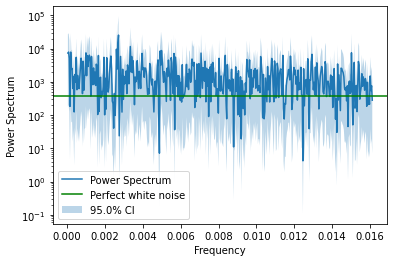

White noise non-coverage of the CI: 0.0%


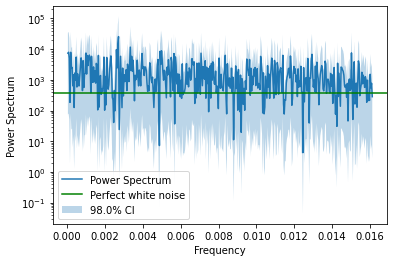

White noise non-coverage of the CI: 0.0%


In [17]:
# Set the significance levels for the confidence intervals
significance_levels = [0.05, 0.02]

# Calculate the confidence intervals
confidence_intervals = calculate_confidence_intervals(power_spectrum[1:], significance_levels)

# Plot the power spectrum with confidence intervals
plot_power_spectrum_with_confidence_intervals(frequencies[1:], power_spectrum[1:], confidence_intervals, significance_levels)

# Try with flawed data

In [21]:
df_flawed = data.drop([4, 10, 55, 56, 399, 400, 401, 402, 403])

In [22]:
# Check if data preprocessing is required
try:
    check_data(df_flawed, 'NAO')
except ValueError as e:
    print(f"Error: {str(e)}")
    # Perform error handling or exit the program as needed

Error: Data contains non-uniform time step. Preprocessing is required. Missing times: DatetimeIndex(['1950-05-31', '1950-11-30', '1954-08-31', '1954-09-30',
               '1983-04-30', '1983-05-31', '1983-06-30', '1983-07-31',
               '1983-08-31'],
              dtype='datetime64[ns]', name='Time', freq=None)


In [23]:
df_flawed_fxd = preprocess_data(df_flawed, 'NAO')

The missing values will be filled by interpolation. This will likely result in a flawed Fourier analysis.
Check if there are better alternatives.


In [24]:
# Check if data preprocessing is required
try:
    check_data(df_flawed_fxd, 'NAO')
except ValueError as e:
    print(f"Error: {str(e)}")
    # Perform error handling or exit the program as needed

In [25]:
# Extract the NAO index values
index_values_flawed_fxd = df_flawed_fxd['NAO'].values

# Determine the sampling rate
time_interval_flawed_fxd = (df_flawed_fxd['Time'].iloc[1] - df_flawed_fxd['Time'].iloc[0]).days  # Assuming the time interval is in days
sampling_rate_flawed_fxd = 1 / time_interval_flawed_fxd

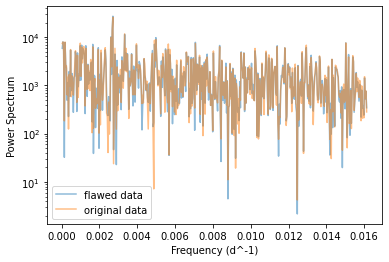

In [26]:
frequencies_flawed_fxd, power_spectrum_flawed_fxd = compute_power_spectrum(index_values_flawed_fxd, sampling_rate_flawed_fxd, method=method)
plt.semilogy(frequencies_flawed_fxd[1:], power_spectrum_flawed_fxd[1:], alpha=0.5, label='flawed data')
    
plt.semilogy(frequencies[1:], power_spectrum[1:], alpha=0.5, label='original data')


plt.legend()
plt.xlabel('Frequency (d^-1)')
plt.ylabel('Power Spectrum')

plt.show()

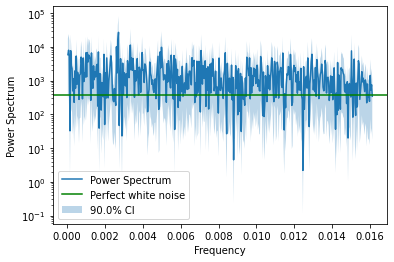

White noise non-coverage of the CI: 0.0%


In [27]:
# Set the significance levels for the confidence intervals
significance_levels = [0.10]

# Calculate the confidence intervals
confidence_intervals_flawed_fxd = calculate_confidence_intervals(power_spectrum_flawed_fxd[1:], significance_levels)

# Plot the power spectrum with confidence intervals
plot_power_spectrum_with_confidence_intervals(frequencies_flawed_fxd[1:], power_spectrum_flawed_fxd[1:], confidence_intervals_flawed_fxd, significance_levels)

Original:

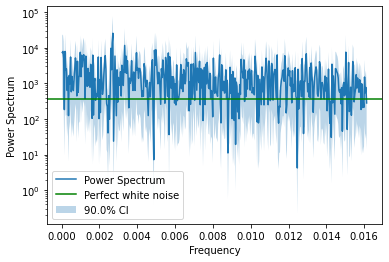

White noise non-coverage of the CI: 0.0%


In [28]:
# Calculate the confidence intervals
confidence_intervals = calculate_confidence_intervals(power_spectrum[1:], significance_levels)

plot_power_spectrum_with_confidence_intervals(frequencies[1:], power_spectrum[1:], confidence_intervals, significance_levels)